# <center> Predict Case Status </center>
                                                                                            M R Abhishek

### Import libraries

In [177]:
import warnings
warnings.filterwarnings('ignore')

import random
import datetime
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import keras
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, f1_score
from sklearn.preprocessing import LabelEncoder
from sklearn.cross_validation import train_test_split
le = LabelEncoder()

import xgboost as xgb
import lightgbm as lgbm
random.seed(20)

pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 200)

### PATH

In [179]:
FOLDER = '../dataset/'
TRAIN_PATH = FOLDER + 'train.csv'
TEST_PATH = FOLDER + 'test.csv'
SAMPLE_SUBMISSION_PATH = FOLDER + 'sample_submission.csv'

### Read data

In [180]:
train_data = pd.read_csv(TRAIN_PATH)
test_data = pd.read_csv(TEST_PATH)
sample_submission = pd.read_csv(SAMPLE_SUBMISSION_PATH)

### Train data

In [181]:
train_data.head()

,CASE_NO,CASE_SUBMITTED_DAY,CASE_SUBMITTED_MONTH,CASE_SUBMITTED_YEAR,DECISION_DAY,DECISION_MONTH,DECISION_YEAR,VISA_CLASS,EMPLOYER_NAME,EMPLOYER_STATE,EMPLOYER_COUNTRY,SOC_NAME,NAICS_CODE,TOTAL_WORKERS,FULL_TIME_POSITION,PREVAILING_WAGE,PW_UNIT_OF_PAY,PW_SOURCE,PW_SOURCE_YEAR,PW_SOURCE_OTHER,WAGE_RATE_OF_PAY_FROM,WAGE_RATE_OF_PAY_TO,WAGE_UNIT_OF_PAY,H-1B_DEPENDENT,WILLFUL_VIOLATOR,WORKSITE_STATE,WORKSITE_POSTAL_CODE,CASE_STATUS
0,9831643,23.0,3,2011,14,4,2017,H1B,XTRON SOFTWARE SERVICES INC,CA,UNITED STATES OF AMERICA,ANALYSTS,541511.0,5,Y,70907.0,Year,OES,2011.0,OFLC ONLINE DATA CENTER,71000.0,91000.0,Year,Y,N,CA,95054,CERTIFIEDWITHDRAWN
1,5075895,28.0,3,2011,10,3,2017,H1B,GLOBAL DISTRIBUTORS INC,MD,UNITED STATES OF AMERICA,ACCOUNTANTS,423210.0,1,Y,50877.0,Year,OES,2010.0,OFLC ONLINE DATA CENTER,51000.0,0.0,Year,N,N,MD,20814,CERTIFIEDWITHDRAWN
2,4040912,17.0,2,2012,18,10,2016,H1B,MARSHALL WEALTH MANAGEMENT LLC,KY,UNITED STATES OF AMERICA,ACTUARIES,523930.0,1,Y,28454.4,Year,OES,2011.0,OFLC ONLINE DATA CENTER,28455.0,0.0,Year,N,N,KY,40202,WITHDRAWN
3,4491642,22.0,3,2012,14,4,2017,H1B,XTRON SOFTWARE SERVICES INC,CA,UNITED STATES OF AMERICA,ANALYSTS,541511.0,5,Y,61963.0,Year,OES,2012.0,OFLC ONLINE DATA CENTER,62000.0,82000.0,Year,Y,N,CA,95054,CERTIFIEDWITHDRAWN
4,3332446,22.0,3,2012,14,4,2017,H1B,XTRON SOFTWARE SERVICES INC,CA,UNITED STATES OF AMERICA,ANALYSTS,541511.0,5,Y,71947.0,Year,OES,2012.0,OFLC ONLINE DATA CENTER,72000.0,92000.0,Year,Y,N,CA,95054,CERTIFIEDWITHDRAWN


# <center> Exploratory Data Analysis </center>

### Errors found in the dataset

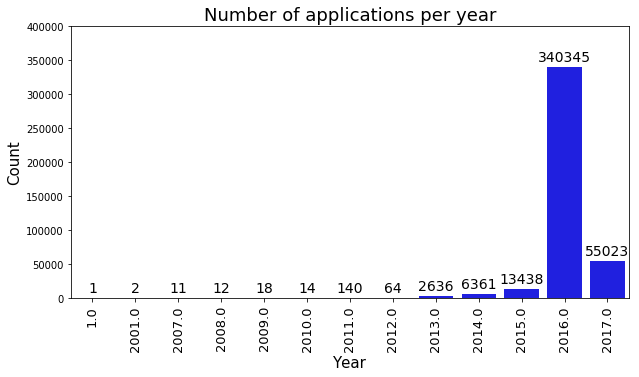

In [182]:
'''
PW_SOURCE_YEAR has year information from 2007 - 2017 and 2001. One of the record has a value of ‘1’, which is 
not an year. Hence, I replaced that value with the mode of all the values in that feature.
'''

year_data = train_data['PW_SOURCE_YEAR'].value_counts()
year_data = pd.DataFrame({'Year': year_data.index, 'Count': year_data.values})

plt.figure(figsize=(10,5))
g = sns.barplot(x='Year', y='Count', data=year_data, capsize=0.9, color='blue') # #1f77b4
g.set_title("Number of applications per year", fontsize=18)
g.set_xlabel("Year", fontsize=15)
g.set_ylabel("Count", fontsize=15)
g.set_xticklabels(g.get_xticklabels(), rotation=90, fontsize=13)
g.set_yticks([0, 50000, 100000, 150000, 200000, 250000, 300000, 350000, 400000])
for p in g.patches:
    g.annotate(np.int(p.get_height()), 
                (p.get_x()+p.get_width()/2., p.get_height()), 
                ha='center', va='center', xytext=(0, 10), 
                textcoords='offset points', fontsize=14, color='black')

In [183]:
'''
It is obvious that WAGE_RATE_OF_PAY_FROM must be greater than WAGE_RATE_OF_PAY_TO. Some of the records in 
WAGE_RATE_OF_PAY_TO contains the value zero(0). So, I replaced those values with the values in 
WAGE_RATE_OF_PAY_FROM.
'''

train_data[['WAGE_RATE_OF_PAY_FROM', 'WAGE_RATE_OF_PAY_TO']].head()

,WAGE_RATE_OF_PAY_FROM,WAGE_RATE_OF_PAY_TO
0,71000.0,91000.0
1,51000.0,0.0
2,28455.0,0.0
3,62000.0,82000.0
4,72000.0,92000.0


### Missing values

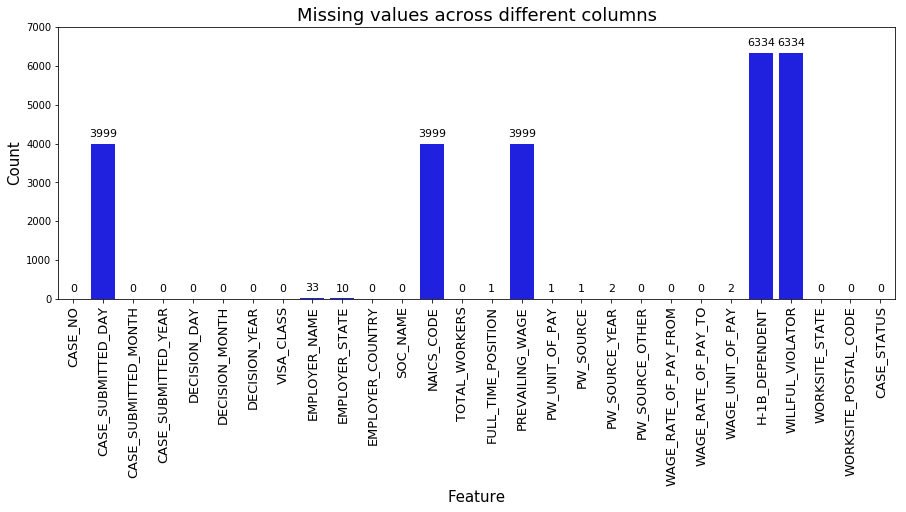

In [184]:
null_values = train_data.isnull().sum()
null_values = pd.DataFrame({'Feature': null_values.index, 'Count': null_values.values})

plt.figure(figsize=(15,5))
g = sns.barplot(x='Feature', y='Count', data=null_values, capsize=0.9, color='blue') # #1f77b4
g.set_title("Missing values across different columns", fontsize=18)
g.set_xlabel("Feature", fontsize=15)
g.set_ylabel("Count", fontsize=15)
g.set_xticklabels(g.get_xticklabels(), rotation=90, fontsize=13)
g.set_yticks([0, 1000, 2000, 3000, 4000, 5000, 6000, 7000])
for p in g.patches:
    g.annotate(np.int(p.get_height()), 
                (p.get_x()+p.get_width()/2., p.get_height()), 
                ha='center', va='center', xytext=(0, 10), 
                textcoords='offset points', fontsize=11, color='black')

### Imbalance dataset

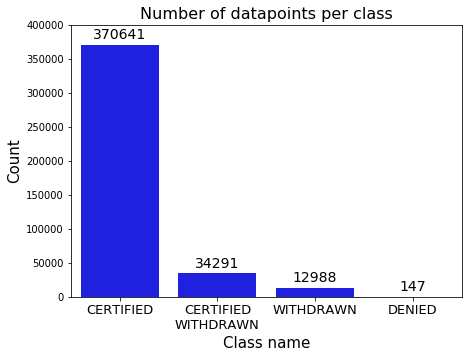

In [136]:
datapoints_per_class = train_data['CASE_STATUS'].value_counts()
datapoints_per_class = pd.DataFrame({'Class': datapoints_per_class.index, 'Count': datapoints_per_class.values})

plt.figure(figsize=(7,5))
g = sns.barplot(x='Class', y='Count', data=datapoints_per_class, capsize=0.9, color='blue') # #1f77b4
g.set_title("Number of datapoints per class", fontsize=16)
g.set_xlabel("Class name", fontsize=15)
g.set_ylabel("Count", fontsize=15)
g.set_xticklabels(['CERTIFIED', "CERTIFIED\nWITHDRAWN", 'WITHDRAWN', 'DENIED'], rotation=0, fontsize=13)
g.set_yticks([0, 50000, 100000, 150000, 200000, 250000, 300000, 350000, 400000])
for p in g.patches:
    g.annotate(np.int(p.get_height()), 
                (p.get_x()+p.get_width()/2., p.get_height()), 
                ha='center', va='center', xytext=(0, 10), 
                textcoords='offset points', fontsize=14, color='black')

### Explore EMPLOYER_NAME feature

In [188]:
'''
Infosys, Capgemini, IBM, TCS, Tech Mahindra, Google are the top companies submitting the applications for their 
employees.
'''

train_data['EMPLOYER_NAME'].value_counts().head(6)

INFOSYS LIMITED                      13188
CAPGEMINI AMERICA INC                 7103
IBM INDIA PRIVATE LIMITED             6870
TATA CONSULTANCY SERVICES LIMITED     6842
TECH MAHINDRA AMERICASINC             6099
GOOGLE INC                            4250
Name: EMPLOYER_NAME, dtype: int64

In [189]:
'''
However, the application is most likely to be accepted if it is from an University. The below table shows the 
number of records per label that are submitted by a University(14369 records).
'''

train_data['EMPLOYER_NAME'] = train_data['EMPLOYER_NAME'].fillna('OTHER')
train_data[train_data['EMPLOYER_NAME'].str.contains('UNIVERSITY')]['CASE_STATUS'].value_counts()

CERTIFIED             10680
CERTIFIEDWITHDRAWN     3228
WITHDRAWN               459
DENIED                    2
Name: CASE_STATUS, dtype: int64

# <center> Preprocessing </center>
- Drop unnecessary features/columns.
- Handle null values.
- Create new features.

### Fill null values

In [145]:
'''
CASE_SUBMITTED_DAY has 3999 null values. Since, this column has day information, I imputed missing values 
by ramdomly sampling numbers between 1 to 28 (if it is between 1 to 31, some of the months may not have that 
many days).
'''

null_case_submitted_day = train_data[train_data['CASE_SUBMITTED_DAY'].isnull()]
null_case_submitted_day.CASE_SUBMITTED_DAY = null_case_submitted_day['CASE_SUBMITTED_DAY'].apply(lambda v: random.randint(1,28))
train_data[train_data['CASE_SUBMITTED_DAY'].isnull()] = null_case_submitted_day

### Create date-time features "CASE_SUBMITTED_DATE", "DECISION_DATE" and "DECISION_PERIOD"

In [146]:
def create_decision_period_column(train_data):
    '''
    Combined (CASE_SUBMITTED_DAY, CASE_SUBMITTED_MONTH, CASE_SUBMITTED_YEAR) and (DECISION_DAY, DECISION_MONTH, DECISION_YEAR) 
    to get CASE_SUBMITTED_DATE and DECISION_DATE date-time features respectively.
    '''
    
    train_data['CASE_SUBMITTED_DAY'] = train_data['CASE_SUBMITTED_DAY'].astype('int')
    train_data['CASE_SUBMITTED_DATE'] = train_data['CASE_SUBMITTED_DAY'].astype('str') + '-' + train_data['CASE_SUBMITTED_MONTH'].astype('str') + '-' + train_data['CASE_SUBMITTED_YEAR'].astype('str')
    train_data['CASE_SUBMITTED_DATE'] = pd.to_datetime(train_data['CASE_SUBMITTED_DATE'], dayfirst=True, format='%d-%m-%Y', errors='coerce')

    train_data['DECISION_DATE'] = train_data['DECISION_DAY'].astype('str') + '-' + train_data['DECISION_MONTH'].astype('str') + '-' + train_data['DECISION_YEAR'].astype('str')
    train_data['DECISION_DATE'] = pd.to_datetime(train_data['DECISION_DATE'], dayfirst=True, format='%d-%m-%Y', errors='coerce')
    
    '''
    Difference between CASE_SUBMITTED_DATE and DECISION_DATE date-time columns which carries information about 
    the gap (in number of days) is labelled as DECISION_PERIOD.
    '''
    
    train_data['DECISION_PERIOD'] = (train_data["DECISION_DATE"] - train_data["CASE_SUBMITTED_DATE"])
    train_data['DECISION_PERIOD'] = train_data.DECISION_PERIOD.apply(lambda x: float(x.days))
    train_data['DECISION_PERIOD'] = train_data.DECISION_PERIOD.astype('int')
    
    return train_data

train_data = create_decision_period_column(train_data)
test_data = create_decision_period_column(test_data)

### A function to impute NULL values and convert categories into numerical values.

In [149]:
def fill_fit_transform(column_name, train_data, test_data, mean_or_mode):
    '''
    Use MODE, if the feature is categorical.
    Use MEAN, if the feature is numerical.
    '''
    
    if mean_or_mode == 'MODE':
        train_data[column_name] = train_data[column_name].fillna(train_data[column_name].mode()[0])
        test_data[column_name] = test_data[column_name].fillna(test_data[column_name].mode()[0])
    elif mean_or_mode == 'MEAN':
        train_data[column_name] = train_data[column_name].fillna(train_data[column_name].mean())
        test_data[column_name] = test_data[column_name].fillna(test_data[column_name].mean())
    
    '''
    Label Encoder is used to transform categorical values into numerical values.
    '''
    
    label_encoder = le.fit(list(train_data[column_name]) + list(test_data[column_name]))
    train_data[column_name] = label_encoder.transform(train_data[column_name]).astype('int')
    test_data[column_name] = label_encoder.transform(test_data[column_name]).astype('int')
    return train_data, test_data

### Drop unnecessary columns
1. CASE_NO - This is a unique number for each CASE. Since, it does not capture any information, I dropped 
this column.
2. EMPLOYER_NAME - This column has been removed because there are many catgories(53,463). Most of the categories 
occur only once. So, it's better to drop this feature.
3. EMPLOYER_COUNTRY - There are 4 categories(USA, CANADA, AUSTRALIA, CHINA) in this column. Out of all Visa cases 
in training set, only 9 belong to CANADA, AUSTRALIA and CHINA. In test data, all the cases belong to USA. As this 
feature is constant in test data, this feature has been dropped.
4. WORKSITE_POSTAL_CODE - There are 17427 categories. I have compared the performance of the models with and without 
this feature. Since, it didnot effect the score much, I dropped this feature.


In [150]:
train_data = train_data.drop(columns = ['CASE_NO', 'EMPLOYER_COUNTRY', 'WORKSITE_POSTAL_CODE', 'CASE_SUBMITTED_DATE', 'DECISION_DATE'])
test_data = test_data.drop(columns = ['CASE_NO', 'EMPLOYER_COUNTRY', 'WORKSITE_POSTAL_CODE', 'CASE_SUBMITTED_DATE', 'DECISION_DATE'])

### Preprocess each column in both train and test at the same time

In [151]:
'''
MEAN(Numerical feature), MODE(Categorical feature), NONE(Only LabelEncoding)
'''

train_data, test_data = fill_fit_transform('VISA_CLASS', train_data, test_data, 'NONE')
train_data, test_data = fill_fit_transform('EMPLOYER_STATE', train_data, test_data, 'MODE')
train_data, test_data = fill_fit_transform('WAGE_UNIT_OF_PAY', train_data, test_data, 'MODE')
train_data, test_data = fill_fit_transform('SOC_NAME', train_data, test_data, 'NONE')
train_data, test_data = fill_fit_transform('NAICS_CODE', train_data, test_data, 'MODE')
train_data, test_data = fill_fit_transform('FULL_TIME_POSITION', train_data, test_data, 'MODE')
train_data, test_data = fill_fit_transform('PREVAILING_WAGE', train_data, test_data, 'MEAN')
train_data, test_data = fill_fit_transform('PW_UNIT_OF_PAY', train_data, test_data, 'MODE')
train_data, test_data = fill_fit_transform('PW_SOURCE', train_data, test_data, 'MODE')
train_data, test_data = fill_fit_transform('H-1B_DEPENDENT', train_data, test_data, 'MODE')
train_data, test_data = fill_fit_transform('WILLFUL_VIOLATOR', train_data, test_data, 'MODE')
train_data, test_data = fill_fit_transform('WORKSITE_STATE', train_data, test_data, 'NONE')

train_data['WAGE_RATE_OF_PAY_FROM'] = train_data['WAGE_RATE_OF_PAY_FROM'].astype('float')
train_data['WAGE_RATE_OF_PAY_TO'] = train_data['WAGE_RATE_OF_PAY_TO'].astype('float')
train_data['PREVAILING_WAGE'] = train_data['PREVAILING_WAGE'].astype('float')
test_data['WAGE_RATE_OF_PAY_FROM'] = test_data['WAGE_RATE_OF_PAY_FROM'].astype('float')
test_data['WAGE_RATE_OF_PAY_TO'] = test_data['WAGE_RATE_OF_PAY_TO'].astype('float')
test_data['PREVAILING_WAGE'] = test_data['PREVAILING_WAGE'].astype('float')

'''
Map categories to numerical values.
'''
train_data['CASE_STATUS'] = train_data['CASE_STATUS'].map({'CERTIFIED': 0, 'CERTIFIEDWITHDRAWN': 1, 'WITHDRAWN': 2, 'DENIED': 3})

In [ ]:
'''
PW_SOURCE_YEAR has year information from 2007 - 2017 and 2001. One of the record has a value of ‘1’, which is 
not an year. Hence, I replaced that value with the mode of all the values in that feature.
'''

train_data.loc[train_data['PW_SOURCE_YEAR'] == 1]['PW_SOURCE_YEAR'] = 2016
train_data, test_data = fill_fit_transform('PW_SOURCE_YEAR', train_data, test_data, 'MODE')

'''
PW_SOURCE_OTHER is a categorical feature that has several categories in which most of the categories have 
occurred less than 10 times. Such categories are clubbed into one category. Around 116 categories are combined 
into one category('OTHER').
'''

other = list(train_data['PW_SOURCE_OTHER'].value_counts()[-116:].index)
train_data['PW_SOURCE_OTHER'] = train_data['PW_SOURCE_OTHER'].replace(other, 'OTHER')
test_data['PW_SOURCE_OTHER'] = test_data['PW_SOURCE_OTHER'].replace(other, 'OTHER')
train_data, test_data = fill_fit_transform('PW_SOURCE_OTHER', train_data, test_data, 'NONE')

'''
It is obvious that WAGE_RATE_OF_PAY_FROM must be greater than WAGE_RATE_OF_PAY_TO. Some of the records in 
WAGE_RATE_OF_PAY_TO contains the value zero(0). So, I replaced those values with the values in 
WAGE_RATE_OF_PAY_FROM.
'''

train_data.ix[train_data['WAGE_RATE_OF_PAY_TO'] == 0, 'WAGE_RATE_OF_PAY_TO'] = train_data[train_data['WAGE_RATE_OF_PAY_TO'] == 0]['WAGE_RATE_OF_PAY_FROM']
test_data.ix[test_data['WAGE_RATE_OF_PAY_TO'] == 0, 'WAGE_RATE_OF_PAY_TO'] = test_data[test_data['WAGE_RATE_OF_PAY_TO'] == 0]['WAGE_RATE_OF_PAY_FROM']

In [ ]:
'''
A new division feature(WAGE_RATE_OF_PAY_FROM/WAGE_RATE_OF_PAY_TO) has been created from WAGE_RATE_OF_PAY_FROM and 
WAGE_RATE_OF_PAY_TO. Most of the methods capture information from the addition and subtraction of features. But, 
it is difficult to extract information from division of two features. So, I have created this feature to extract 
hidden information. This feature has increased the F1 score.
'''

train_data['RATIO_OF_PAY_FROM_TO'] = train_data['WAGE_RATE_OF_PAY_FROM']/train_data['WAGE_RATE_OF_PAY_TO']
test_data['RATIO_OF_PAY_FROM_TO'] = test_data['WAGE_RATE_OF_PAY_FROM']/test_data['WAGE_RATE_OF_PAY_TO']

In [152]:
'''
A new boolean feature IS_ES_SAMEAS_WS is added which tells whether the EMPLOYER_STATE and WORKSITE_STATE 
are the same or not.
'''

train_data['IS_ES_SAMEAS_WS'] = train_data['EMPLOYER_STATE'] != train_data['WORKSITE_STATE']
train_data['IS_ES_SAMEAS_WS'] = train_data['IS_ES_SAMEAS_WS'].map({True: 1, False: 0})

test_data['IS_ES_SAMEAS_WS'] = test_data['EMPLOYER_STATE'] != test_data['WORKSITE_STATE']
test_data['IS_ES_SAMEAS_WS'] = test_data['IS_ES_SAMEAS_WS'].map({True: 1, False: 0})

In [154]:
'''
A boolean feature ‘IS_UNIVERSITY’ is created which tells whether the application is from a University or not.
'''

column_name = 'EMPLOYER_NAME'
train_data[column_name] = train_data[column_name].fillna(train_data[column_name].mode()[0])
test_data[column_name] = test_data[column_name].fillna(test_data[column_name].mode()[0])

train_data['IS_UNIVERSITY'] = np.nan
train_data['EMPLOYER_NAME'] = train_data['EMPLOYER_NAME'].str.lower()
train_data.IS_UNIVERSITY[train_data['EMPLOYER_NAME'].str.contains('university')] = 1
train_data['IS_UNIVERSITY']= train_data.IS_UNIVERSITY.replace(np.nan, 0, regex=True)
train_data['IS_UNIVERSITY'] = train_data.IS_UNIVERSITY.astype('int')

test_data['IS_UNIVERSITY'] = np.nan
test_data['EMPLOYER_NAME'] = test_data['EMPLOYER_NAME'].str.lower()
test_data.IS_UNIVERSITY[test_data['EMPLOYER_NAME'].str.contains('university')] = 1
test_data['IS_UNIVERSITY']= test_data.IS_UNIVERSITY.replace(np.nan, 0, regex=True)
test_data['IS_UNIVERSITY'] = test_data.IS_UNIVERSITY.astype('int')

train_data = train_data.drop(columns=['EMPLOYER_NAME'])
test_data = test_data.drop(columns=['EMPLOYER_NAME'])

### Upsample lower class data-points

In [155]:
'''
Since the dataset provided is imbalanced, I manually up-sampled the data-points with lower class by 20 times.
'''

class_two_data = train_data[train_data['CASE_STATUS'] == 2]

class_three_data = train_data[train_data['CASE_STATUS'] == 3]
copy_of_class_three_data = class_three_data.copy()
for i in range(1, 20):
    class_three_data = class_three_data.append(copy_of_class_three_data, ignore_index=False)

train_data = train_data.append(class_three_data, ignore_index=False)
train_data = train_data.append(class_two_data, ignore_index=False)

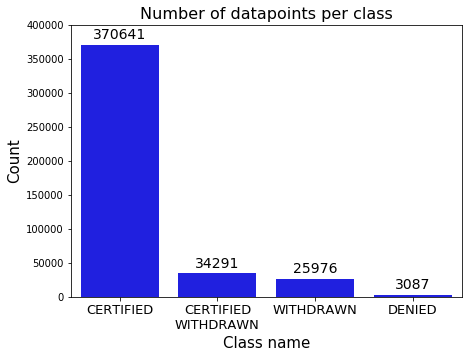

In [157]:
datapoints_per_class = train_data['CASE_STATUS'].value_counts()
datapoints_per_class = pd.DataFrame({'Class': datapoints_per_class.index, 'Count': datapoints_per_class.values})

plt.figure(figsize=(7,5))
g = sns.barplot(x='Class', y='Count', data=datapoints_per_class, capsize=0.9, color='blue') # #1f77b4
g.set_title("Number of datapoints per class", fontsize=16)
g.set_xlabel("Class name", fontsize=15)
g.set_ylabel("Count", fontsize=15)
g.set_xticklabels(['CERTIFIED', "CERTIFIED\nWITHDRAWN", 'WITHDRAWN', 'DENIED'], rotation=0, fontsize=13)
g.set_yticks([0, 50000, 100000, 150000, 200000, 250000, 300000, 350000, 400000])
for p in g.patches:
    g.annotate(np.int(p.get_height()), 
                (p.get_x()+p.get_width()/2., p.get_height()), 
                ha='center', va='center', xytext=(0, 10), 
                textcoords='offset points', fontsize=14, color='black')

### Final data - X_train and y_train

In [159]:
X_train = train_data.drop(columns=['CASE_STATUS'])
y_train = train_data['CASE_STATUS']

'''
Split the dataset into train and validation sets.
'''

train_X, val_X, train_y, val_y = train_test_split(X_train, y_train, test_size=0.3, random_state=0)
dummy_test_data = pd.read_csv(TEST_PATH)

test_data = test_data[train_X.columns]

# <center> Modelling - XGBoost </center>

### Model 1

In [160]:
xgb_model_1 = xgb.XGBClassifier(objective = 'multi:softmax', 
                              n_estimators = 100, 
                              max_depth = 3,
                              colsample_bylevel = 0.9,
                              learning_rate = 0.1,
                              random_state=12)

xgb_model_1.fit(X_train, y_train, eval_set=[(val_X, val_y)], verbose=False, early_stopping_rounds=3)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=0.9,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='multi:softprob', random_state=12,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [161]:
y_valid_pred_1 = xgb_model_1.predict(val_X)
print ('F1 score - ' + str(f1_score(y_valid_pred_1, val_y, average='weighted')))

F1 score - 0.9761484488623773


In [162]:
y_pred_1 = xgb_model_1.predict(test_data)
y_pred_1 = pd.DataFrame({'CASE_NO': dummy_test_data['CASE_NO'], 'CASE_STATUS': y_pred_1})
y_pred_1['CASE_STATUS'] = y_pred_1['CASE_STATUS'].map({0: 'CERTIFIED', 1: 'CERTIFIEDWITHDRAWN', 2: 'WITHDRAWN', 3: 'DENIED'})
y_pred_1.to_csv('1_prediction_xgboost.csv', index=False)

### Significant variables

In [163]:
def feature_importance(model, X_train):
    importances = model.feature_importances_
    indices = np.argsort(importances)[::-1]
    features = X_train.columns
    important_features = []
    important_features_scores = []
    for index in indices:
        important_features.append(features[index])
        important_features_scores.append(importances[index])
    feature_importance_df = pd.Series(data=important_features_scores, index=important_features)
    return feature_importance_df

Text(0.5,1,'Feature Importance')

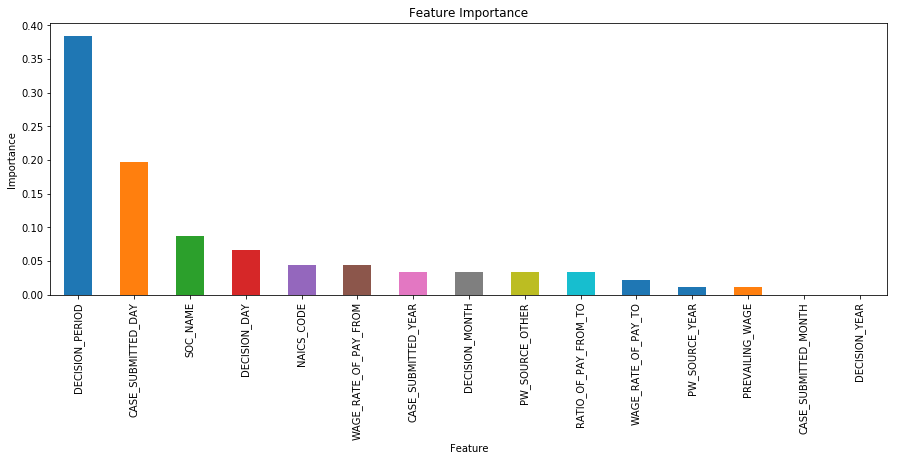

In [164]:
plt.figure(figsize=(15,5))
feature_importance_df_1 = feature_importance(xgb_model_1, X_train)
feature_importance_df_1.iloc[:15].plot('bar')
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('Feature Importance')

### Model 2

In [165]:
xgb_model_2 = xgb.XGBClassifier(objective = 'multi:softmax', 
                              n_estimators = 80, 
                              max_depth = 5,
                              colsample_bylevel = 0.9,
                              learning_rate = 0.1,
                              random_state=12)

xgb_model_2.fit(X_train, y_train, eval_set=[(val_X, val_y)], verbose=False, early_stopping_rounds=3)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=0.9,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=5, min_child_weight=1, missing=None, n_estimators=80,
       n_jobs=1, nthread=None, objective='multi:softprob', random_state=12,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [166]:
y_valid_pred_2 = xgb_model_2.predict(val_X)
print ('F1 score - ' + str(f1_score(y_valid_pred_2, val_y, average='weighted')))

F1 score - 0.9794831488102878


In [167]:
y_pred_2 = xgb_model_2.predict(test_data)
y_pred_2 = pd.DataFrame({'CASE_NO': dummy_test_data['CASE_NO'], 'CASE_STATUS': y_pred_2})
y_pred_2['CASE_STATUS'] = y_pred_2['CASE_STATUS'].map({0: 'CERTIFIED', 1: 'CERTIFIEDWITHDRAWN', 2: 'WITHDRAWN', 3: 'DENIED'})
y_pred_2.to_csv('2_prediction_xgboost.csv', index=False)

Text(0.5,1,'Feature Importance')

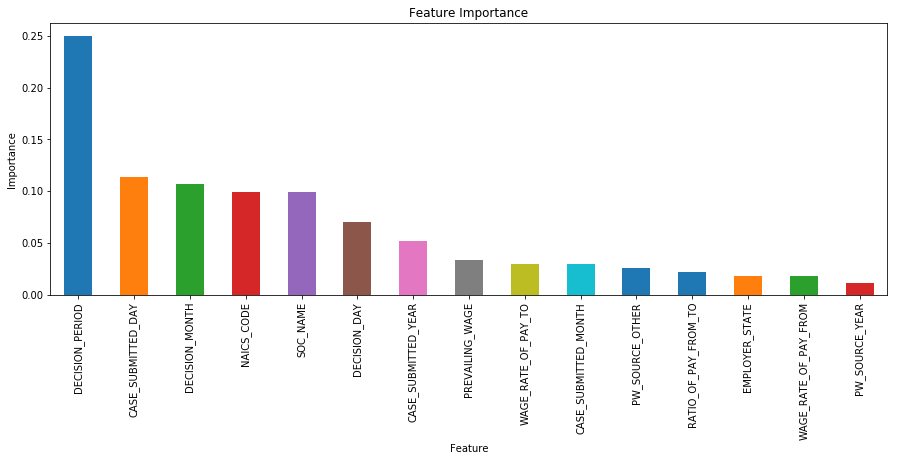

In [168]:
plt.figure(figsize=(15,5))
feature_importance_df_2 = feature_importance(xgb_model_2, X_train)
feature_importance_df_2.iloc[:15].plot('bar')
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('Feature Importance')

### Model 3

In [169]:
xgb_model_3 = xgb.XGBClassifier(objective = 'multi:softmax', 
                              n_estimators = 100, 
                              max_depth = 2,
                              colsample_bylevel = 1,
                              learning_rate = 0.01,
                              random_state=12)

xgb_model_3.fit(X_train, y_train, eval_set=[(val_X, val_y)], verbose=False, early_stopping_rounds=3)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.01, max_delta_step=0,
       max_depth=2, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='multi:softprob', random_state=12,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [170]:
y_valid_pred_3 = xgb_model_3.predict(val_X)
print ('F1 score - ' + str(f1_score(y_valid_pred_3, val_y, average='weighted')))

F1 score - 0.9702938143165597


In [171]:
y_pred_3 = xgb_model_3.predict(test_data)
y_pred_3 = pd.DataFrame({'CASE_NO': dummy_test_data['CASE_NO'], 'CASE_STATUS': y_pred_3})
y_pred_3['CASE_STATUS'] = y_pred_3['CASE_STATUS'].map({0: 'CERTIFIED', 1: 'CERTIFIEDWITHDRAWN', 2: 'WITHDRAWN', 3: 'DENIED'})
y_pred_3.to_csv('3_prediction_xgboost.csv', index=False)

Text(0.5,1,'Feature Importance')

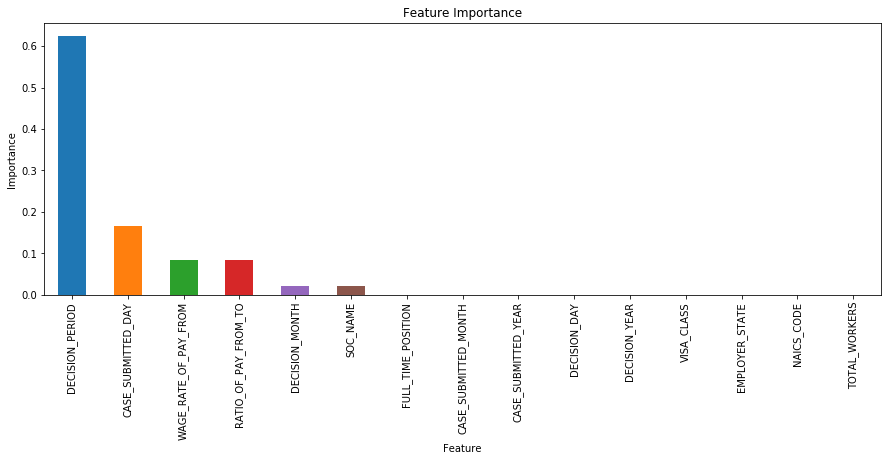

In [172]:
plt.figure(figsize=(15,5))
feature_importance_df_3 = feature_importance(xgb_model_3, X_train)
feature_importance_df_3.iloc[:15].plot('bar')
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('Feature Importance')

## Ensemble

In [173]:
'''
For my final submission, I applied 3 XGBoost models by varying n_estimators, max_depth, random_state, 
learning_rate parameters and ensembled the three. I took mode of the three outputs and finally achieved best score 
of 97.99 on LB. However, XGBoost outperformed other models.

The final model was the mode of three XGBoost models.
'''

Ensemble = pd.DataFrame({'1': y_pred_1.CASE_STATUS, '2': y_pred_2.CASE_STATUS,
                         '3': y_pred_3.CASE_STATUS})
case_status = np.array(Ensemble.mode(axis=1))[:, 0]
y_pred = pd.DataFrame({'CASE_NO': y_pred_1.CASE_NO,'CASE_STATUS': case_status})
y_pred.to_csv('ensemble_predictions.csv', index=False)